# Setup

In [1]:
import matplotlib.pyplot as plt
import torch
from torchdyn.core import NeuralODE

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler


In [2]:
def plot_trajectories(traj):
    """Plot trajectories of some selected samples."""
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=6, alpha=1, c="blue")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.2, c="black")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=6, alpha=1, c="red")
    plt.legend(["$q_0$", 'Flow', "$q_1$"])
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def plot_samples(x0, x1):
    """Plot trajectories of some selected samples."""
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(x0[:n, 0], x0[:n, 1], s=6, alpha=1, c="blue")
    plt.scatter(x1[ :n, 0], x1[ :n, 1], s=6, alpha=1, c="red")
    plt.legend(["$q_0$", "$q_1$"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [3]:
def logging(k, loss, model):
    print(f"{k+1}: loss {loss.item():0.3f}")
    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            sample_8gaussians(1024),
            t_span=torch.linspace(0, 1, 100),
        )
        plot_trajectories(traj.cpu().numpy())

# Dataset

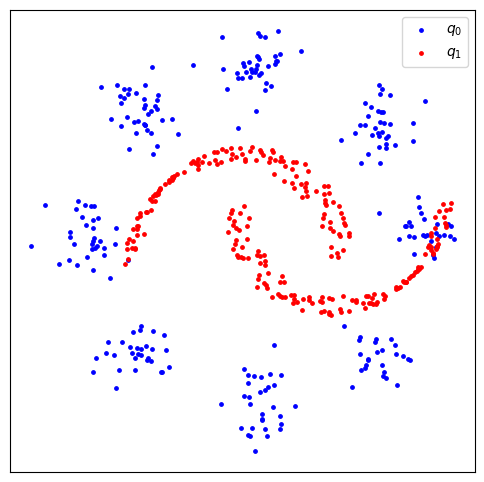

In [4]:
batch_size = 256
x0 = sample_8gaussians(batch_size)
x1 = sample_moons(batch_size)
plot_samples(x0, x1)

## Training

$p_t$ describes our path from $x_0$ to $x_1$.  To be more precise, $p_t$ is a time dependent probability density function which can be modelled simply with a Gaussian distribution where $\mu$ is a linear interpolation between $x_0$ and $x_1$, and $\sigma$ is a small constant greater than $0$.

$$ p_t(x|x_1) = \mathcal{N}(x | tx_1 + (1 − t)x_0, \sigma^2) $$

In [5]:
def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    ###############################
    mean = t * x1 + (1 - t) * x0
    noise = torch.randn_like(x0)
    return mean + sigma * noise 
    ###############################

Training will use the $\mathcal{L}_{\text{CFM}}$ loss function and use the following optimization process:

1. $~~\text{repeat}$
2. $~~~~~~x_1 \sim q_1$
3. $~~~~~~t \sim \text{Uniform}(0,1)$
4. $~~~~~~x \sim p_t$
5. $~~~~~~\text{taking gradient descent step on}$
6. $~~~~~~~~~~~∇_{θ}\| v_t(x) - u_t(x|x_1) \|^2$
7. $~~~~~~\text{until convergence}$

1000: loss 0.337


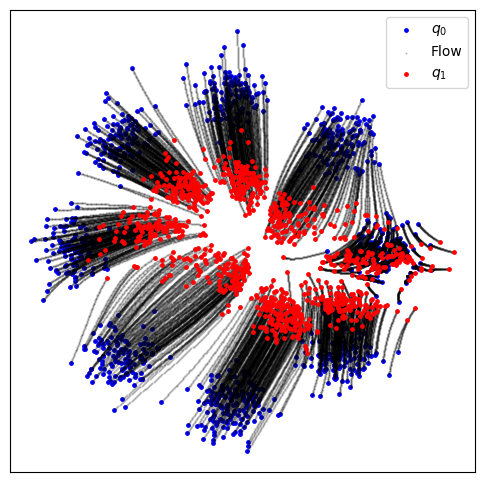

2000: loss 0.307


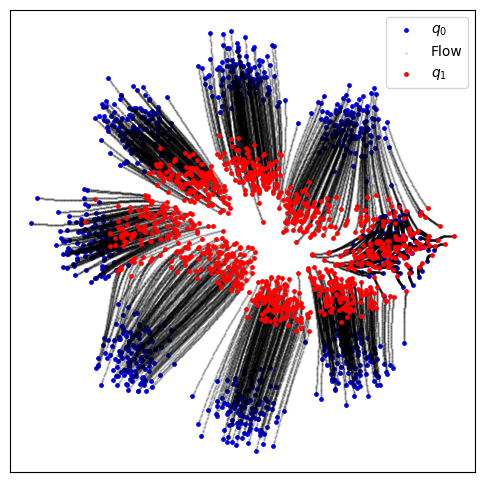

3000: loss 0.165


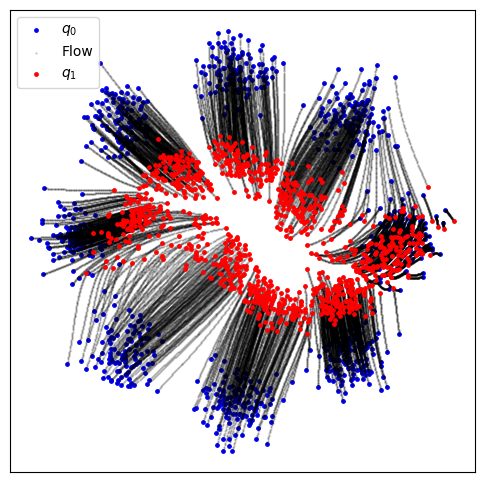

4000: loss 0.197


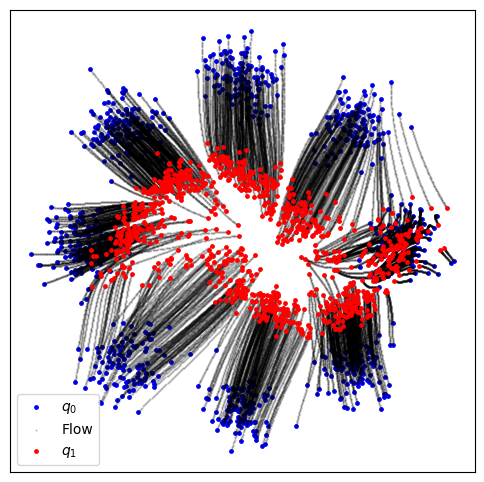

5000: loss 0.148


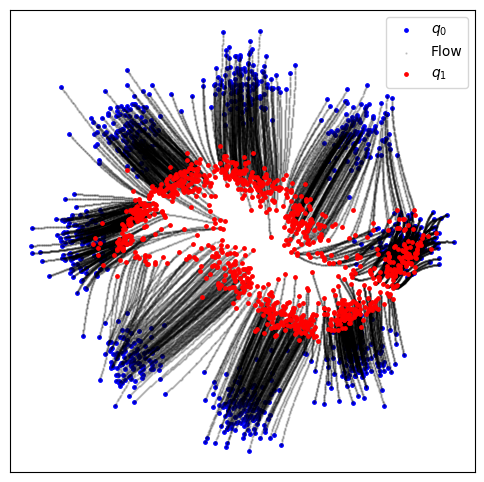

In [6]:
# Hyperparameters
sigma = 0.1
dim = 2

# Create neural network and optimizer
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
ot_sampler = OTPlanSampler(method="exact")

# Training Loop
for k in range(5000):
    optimizer.zero_grad()

    # Training Step
    ###############################
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    
    x0, x1 = ot_sampler.sample_plan(x0, x1)
    
    t = torch.rand(batch_size,1).type_as(x0)
    x = sample_conditional_pt(x0, x1, t, sigma)
    ut = x1 - x0
    
    vt = model(torch.cat([x,t], axis=-1))
    loss = torch.mean((vt - ut)  ** 2)
    ###############################

    # Backprop through the network
    loss.backward()
    optimizer.step()

    # Log the training loss
    if (k + 1) % 1000 == 0:
        logging(k, loss, model)